# MODUL PINA (Python 3.12)

# Vorhersage des Ödometerversuches implementiert
Ziel war die Implementierung eines neuronalen Netzwerks zur Modellierung des Ödometerversuchs. Dabei wurden gegebene Input-Parameter verarbeitet, um Output-Parameter vorherzusagen. Die physikalischen Rahmenbedingungen wurden zunächst auf Null gesetzt, sodass das Modell ausschließlich auf der KI-basierten Struktur arbeitet, ohne physikalische Optimierungen durch Physical Informed Neural Networks (PINNs).
<br>
Diese grundlegende Umsetzung bildet die Basis für weiterführende Optimierungen, wie die Integration physikalischer Gesetzmäßigkeiten, die jedoch nicht Teil des initialen Arbeitsauftrags waren.

#### Das Problem ist wie folgt definiert:
$$
\begin{array}{rcl}
    \sigma_{t+1} & = & \sigma_{t}+\Delta\sigma \\ \\
    \Delta\sigma & = & E_s\cdot \Delta\epsilon \\ 
    E_s & = & \frac{1+e_0}{C_c} \cdot \sigma_t
\end{array}
\hspace{2cm}
\begin{array}{l}
    \textbf{Annahmen:} \\ \\
    \text{Startwert d. Iteration: } \sigma_t = 1,00 \\ 
    e_0 = 1,00 \\ 
    C_c = 0,005 \\
    \Delta\epsilon = 0,0005
\end{array}
$$

<br> 

Um das PINA-Model zu testen werden wir folgende vorberechnete Werte verwenden: `Input` { $\sigma_t$ }, `Output` { $E_s$ }.
<br>
### Variablendeklaration
- $\sigma_t$ = `sigma_t`
- $\Delta\epsilon$ = `delta_epsilon`
- $\sigma_{t+1}$ = `delta_sigma
- $E_s$ = `e_s`

# Generating random trainings data

In [1]:
from random import randint

# Define input and output parameters
input_str = "sigma_t"
output_str = "e_s"

# Defining problem parameters
delta_epsilon=0.0005
C_c = 0.005
e_0 = 1.0
amount_trainings_data = 100

# Data preparation for 
oedo_para = {
    'max_n': 1,
    'e_0': e_0,
    'C_c': C_c,
    'delta_epsilon' : delta_epsilon,
}

# Load problem and generate  data from 00_problem_settings_functions.ipynb

Available classes: `Oedometer` <br>
Returns `list_input` and `list_output` as type `list` <br>
Returns `tensor_input` and `tensor_output` as type `tensor`

In [2]:
%run 00_problem_settings_functions.ipynb

# Loads:
# Oedometer class

# Returns
# list_input: list
# list_output: list

# tensor_input: tensor
# tensor_output: tensor

# Show trainingsdata (List) as DataFrame
Type `list`: `list_input` and `list_output`

In [3]:
import pandas as pd
from pandas import DataFrame

pd.DataFrame([[input_str] + list_input, [output_str] + list_output])

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,sigma_t,20.0,30.0,15.0,20.0,18.0,4.0,33.0,25.0,6.0,...,44.0,39.0,50.0,14.0,5.0,26.0,16.0,4.0,24.0,20.0
1,e_s,8000.0,12000.0,6000.0,8000.0,7200.0,1600.0,13200.0,10000.0,2400.0,...,17600.0,15600.0,20000.0,5600.0,2000.0,10400.0,6400.0,1600.0,9600.0,8000.0


# Show trainingsdata (Tensor) as DataFrame
Type `tensor`: `tensor_input` and `tensor_output`

In [4]:
tensor_data_df = pd.DataFrame(torch.cat((tensor_input, tensor_output), dim=1), columns = [input_str, output_str])
tensor_data_df

,sigma_t,e_s
0,20.0,8000.0
1,30.0,12000.0
2,15.0,6000.0
3,20.0,8000.0
4,18.0,7200.0
...,...,...
95,26.0,10400.0
96,16.0,6400.0
97,4.0,1600.0
98,24.0,9600.0


## Tensor to LabelTensor for PINA

In [5]:
from pina.utils import LabelTensor

label_tensor_input = LabelTensor(tensor_input,[input_str])
label_tensor_output = LabelTensor(tensor_output, [output_str])

# Show trainingsdata (LabelTensor) as DataFrame
Type `LabelTensor`: `label_tensor_input` and `label_tensor_output`

In [6]:
tensor_input_df = pd.DataFrame(torch.cat((label_tensor_input, label_tensor_output), dim=1), columns = [input_str, output_str])

print('Input Size: ', label_tensor_input.size())
print('Output Size: ', label_tensor_output.size(), '\n')
tensor_input_df

Input Size:  torch.Size([100, 1])
Output Size:  torch.Size([100, 1]) 



,sigma_t,e_s
0,20.0,8000.0
1,30.0,12000.0
2,15.0,6000.0
3,20.0,8000.0
4,18.0,7200.0
...,...,...
95,26.0,10400.0
96,16.0,6400.0
97,4.0,1600.0
98,24.0,9600.0


### **Definition eines PINN-Problems in PINA**  

In [7]:
from pina.problem import AbstractProblem
from pina.domain import CartesianDomain
from pina import Condition

input_conditions = {'data': Condition(input=label_tensor_input, target=label_tensor_output),}

class SimpleODE(AbstractProblem):

    # Definition der Eingabe- und Ausgabevariablen basierend auf LabelTensor
    input_variables = label_tensor_input.labels
    output_variables = label_tensor_output.labels

    # Wertebereich
    domain = CartesianDomain({label_tensor_input: [0, 1]})#, 'delta_epsilon': [0, 1]})  # Wertebereich immer definieren!

    # Definition der Randbedingungen und (hier: nur) vorberechnetet Punkte
    conditions = input_conditions

    label_tensor_output=label_tensor_output

    # Methode zur Definition der "wahren Lösung" des Problems
    def truth_solution(self, pts):
        return torch.exp(pts.extract(label_tensor_input))

# Problem-Instanz erzeugen
problem = SimpleODE()

print('Input: ', problem.input_variables)
print('Output: ', problem.output_variables)

Input:  ['sigma_t']
Output:  ['e_s']


# Training eines Physics-Informed Neural Networks (PINN) mit PINA

In [8]:
from pina import Trainer
from pina.solver import PINN
from pina.model import FeedForward
from pina.callback import MetricTracker
import torch.nn as nn
# Model erstellen
model = FeedForward(
    layers=[50,50,50],
    func=nn.ReLU,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

# PINN-Objekt erstellen
pinn = PINN(problem, model)

# Trainer erstellen mit TensorBoard-Logger
trainer = Trainer(
    solver=pinn,
    max_epochs=1000,
    callbacks=[MetricTracker()],
    batch_size=16,
    accelerator='cpu',
    enable_model_summary=False,
)


# Training starten
trainer.train()

print('\nFinale Loss Werte')
# Inspect final loss
trainer.logged_metrics

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mrschiller/Dokumente/git_projects/nn_oedometer_lstm/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/mrschiller/Dokumente/git_projects/nn_oedometer_lstm/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensor

Epoch 999: 100%|█| 7/7 [00:00<00:00, 126.66it/s, v_num=0, data_loss_step=0.446, 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|█| 7/7 [00:00<00:00, 113.17it/s, v_num=0, data_loss_step=0.446, 

Finale Loss Werte


{'data_loss_step': tensor(0.4465),
 'train_loss_step': tensor(0.4465),
 'data_loss_epoch': tensor(0.3878),
 'train_loss_epoch': tensor(0.3878)}

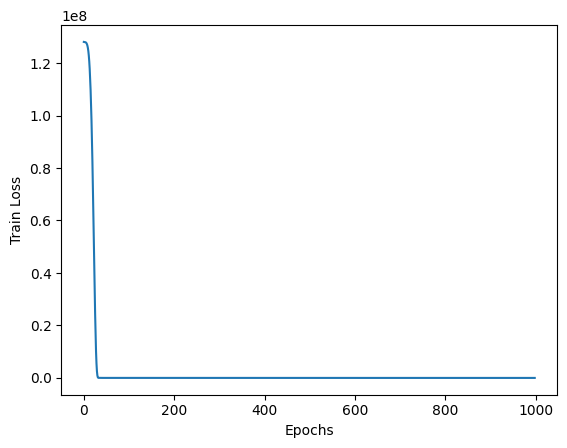

In [9]:
import matplotlib.pyplot as plt

data_loss = trainer.callbacks[0].metrics["train_loss_epoch"].tolist()

plt.plot(data_loss, label="Loss")
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.show()

# Plot of stress–strain curve

<>: SyntaxWarning: invalid escape sequence '\s'
<>: SyntaxWarning: invalid escape sequence '\s'
<>: SyntaxWarning: invalid escape sequence '\s'
<>: SyntaxWarning: invalid escape sequence '\s'
<>: SyntaxWarning: invalid escape sequence '\D'
<>: SyntaxWarning: invalid escape sequence '\s'
<>: SyntaxWarning: invalid escape sequence '\s'
<>: SyntaxWarning: invalid escape sequence '\s'
<>: SyntaxWarning: invalid escape sequence '\s'
<>: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_6718/3899886523.py: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_6718/3899886523.py: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_6718/3899886523.py: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_6718/3899886523.py: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_6718/3899886523.py: SyntaxWarning: invalid escape sequence '\D'


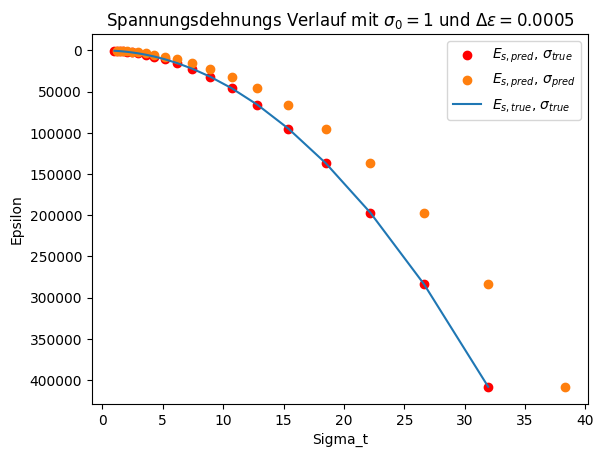

In [27]:
def plot_result(iterations=20, start_sigma=1, delta_epsilon=0.0005):
    oedo_para = {
    'max_n': iterations,
    'e_0': 1.0,
    'C_c': 0.005,
    'delta_epsilon' : delta_epsilon,
    'sigma_t' : start_sigma,
    }

    oedo = Oedometer(**oedo_para)
    sigma_true = oedo.sigma_t
    e_s_true = oedo.e_s
    
    # print(sigma_true)
    # print(e_s_true)
    model.eval()
    e_s_pred = []
    e_s_true_plot = []
    sigma_t = start_sigma
    sigma_pred = []
    with torch.no_grad():
        for i in range(iterations):
            sigma_true_tensor = torch.tensor(sigma_true[i], dtype=torch.float).unsqueeze(-1) 
            pred = model(sigma_true_tensor)
            e_s_pred.append(pred * sigma_true[i])
            e_s_true_plot.append(e_s_true[i] * sigma_true[i])
            sigma_t = sigma_t + pred * delta_epsilon
            sigma_pred.append(sigma_t)
            
    # Plot der Losskurve
    plt.scatter(sigma_true, e_s_pred, label='$E_{s,pred}$, $\sigma_{true}$').set_color("red")
    plt.scatter(sigma_pred, e_s_pred, label='$E_{s,pred}$, $\sigma_{pred}$')
    plt.plot(sigma_true, e_s_true_plot, label='$E_{s,true}$, $\sigma_{true}$')

    plt.gca().invert_yaxis()
    plt.xlabel('Sigma_t')
    plt.ylabel('Epsilon')
    plt.title(f'Spannungsdehnungs Verlauf mit $\sigma_0={start_sigma}$ und $\Delta\epsilon=0.0005$')
    plt.legend()
    plt.show()
plot_result()